# Decision trees to predict the CO2 emissions of a car

## Libraries installation

In [2264]:
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install tabulate


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Dataset description

|           Attribute            |                                       Description                                        |
|:------------------------------:|:----------------------------------------------------------------------------------------:|
|       1 (`engine_size`)        |                                  Engine size in liters.                                  |
|        2 (`cylinders`)         |                            Number of cylinders in the engine.                            |
|  3 (`fuel_consumption_city`)   | Fuel consumption of the vehicle in urban area ($\frac{ \text{ L } }{ 100 } \text{ km }$) |
| 4 (`fuel_consumption_highway`) |  Fuel consumption of the vehicle in highway ($\frac{ \text{ L } }{ 100 } \text{ km }$)   |
|      5 (`CO2_emissions`)       |         CO2 emissions of the vehicle, where $0$ means "Low" and $1$ means "High"         |

In [2265]:
import sklearn
import warnings
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2266]:
import pandas as pd


source = "data.csv"
data = pd.read_csv(source, sep=",")

data.columns = [
	"engine_size",
	"cylinders",
	"fuel_consumption_city",
	"fuel_consumption_highway",
	"CO2_emissions",
]

In [2267]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   engine_size               1067 non-null   float64
 1   cylinders                 1067 non-null   int64  
 2   fuel_consumption_city     1067 non-null   float64
 3   fuel_consumption_highway  1067 non-null   float64
 4   CO2_emissions             1067 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 41.8 KB


## Quantitative variables

### `int64`

In [2268]:
data.select_dtypes(include=["int64"]).describe()

,cylinders,CO2_emissions
count,1067.000000,1067.000000
mean,5.794752,0.461106
std,1.797447,0.498719
min,3.000000,0.000000
25%,4.000000,0.000000
50%,6.000000,0.000000
75%,8.000000,1.000000
max,12.000000,1.000000


### `float64`

In [2269]:
data.select_dtypes(include=["float64"]).describe()

,engine_size,fuel_consumption_city,fuel_consumption_highway
count,1067.000000,1067.000000,1067.000000
mean,3.346298,13.296532,9.474602
std,1.415895,4.101253,2.794510
min,1.000000,4.600000,4.900000
25%,2.000000,10.250000,7.500000
50%,3.400000,12.600000,8.800000
75%,4.300000,15.550000,10.850000
max,8.400000,30.200000,20.500000


## Data separation

In [2270]:
from sklearn.model_selection import train_test_split


total = len(data)
train = int(total * 0.8)
test = total - train
print(total, train, test)

train_data, test_data = sklearn.model_selection.train_test_split(data, train_size=train, test_size=test, random_state=123)



1067 853 214


In [2271]:
print(train_data.shape)
train_data.info()

(853, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 853 entries, 84 to 1041
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   engine_size               853 non-null    float64
 1   cylinders                 853 non-null    int64  
 2   fuel_consumption_city     853 non-null    float64
 3   fuel_consumption_highway  853 non-null    float64
 4   CO2_emissions             853 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 40.0 KB


## Pipelining

### Numeric attributes (pipeline)

In [2272]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


numeric_attributes = [
	"engine_size",
	"cylinders",
	"fuel_consumption_city",
	"fuel_consumption_highway"
]

numeric_pipeline = Pipeline([
						("imputer", SimpleImputer(strategy="median")),
						("scaler", StandardScaler())
					])

### Full pipeline

In [2273]:
from sklearn.compose import ColumnTransformer


full_pipeline = ColumnTransformer([
					("num", numeric_pipeline, numeric_attributes)
				])

In [2274]:
x_train = full_pipeline.fit_transform(train_data)
y_train = train_data["CO2_emissions"]

x_test = full_pipeline.transform(test_data)
y_test = test_data["CO2_emissions"]

## Models

In [2275]:
criterions = ["gini", "entropy"]
splitters = ["best", "random"]
max_depths = range(1, 11)

models = [(criterion, splitter, depth) 
          for criterion in criterions 
          for splitter in splitters if not (criterion == "gini" and splitter == "random")
          for depth in max_depths]

print(models)

[('gini', 'best', 1), ('gini', 'best', 2), ('gini', 'best', 3), ('gini', 'best', 4), ('gini', 'best', 5), ('gini', 'best', 6), ('gini', 'best', 7), ('gini', 'best', 8), ('gini', 'best', 9), ('gini', 'best', 10), ('entropy', 'best', 1), ('entropy', 'best', 2), ('entropy', 'best', 3), ('entropy', 'best', 4), ('entropy', 'best', 5), ('entropy', 'best', 6), ('entropy', 'best', 7), ('entropy', 'best', 8), ('entropy', 'best', 9), ('entropy', 'best', 10), ('entropy', 'random', 1), ('entropy', 'random', 2), ('entropy', 'random', 3), ('entropy', 'random', 4), ('entropy', 'random', 5), ('entropy', 'random', 6), ('entropy', 'random', 7), ('entropy', 'random', 8), ('entropy', 'random', 9), ('entropy', 'random', 10)]


In [2276]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

models_results = []

for criterion, splitter, max_depth in models:
    model = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, random_state=123)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    models_results.append((criterion, splitter, max_depth, accuracy))

## Results (models)

In [2277]:
results_df = pd.DataFrame(models_results, columns=["Criterion", "Splitter", "Max Depth", "Accuracy"])
print(results_df)

   Criterion Splitter  Max Depth  Accuracy
0       gini     best          1  0.948598
1       gini     best          2  0.943925
2       gini     best          3  0.943925
3       gini     best          4  0.939252
4       gini     best          5  0.962617
5       gini     best          6  0.953271
6       gini     best          7  0.953271
7       gini     best          8  0.957944
8       gini     best          9  0.957944
9       gini     best         10  0.957944
10   entropy     best          1  0.948598
11   entropy     best          2  0.953271
12   entropy     best          3  0.948598
13   entropy     best          4  0.943925
14   entropy     best          5  0.967290
15   entropy     best          6  0.957944
16   entropy     best          7  0.957944
17   entropy     best          8  0.962617
18   entropy     best          9  0.962617
19   entropy     best         10  0.962617
20   entropy   random          1  0.813084
21   entropy   random          2  0.813084
22   entrop

### Gini - Best


In [2278]:
gini_best = results_df[(results_df['Criterion'] == 'gini') & (results_df['Splitter'] == 'best')]

print(gini_best)

  Criterion Splitter  Max Depth  Accuracy
0      gini     best          1  0.948598
1      gini     best          2  0.943925
2      gini     best          3  0.943925
3      gini     best          4  0.939252
4      gini     best          5  0.962617
5      gini     best          6  0.953271
6      gini     best          7  0.953271
7      gini     best          8  0.957944
8      gini     best          9  0.957944
9      gini     best         10  0.957944


### Entropy - Best

In [2279]:
entropy_best = results_df[(results_df['Criterion'] == 'entropy') & (results_df['Splitter'] == 'best')]

print(entropy_best)

   Criterion Splitter  Max Depth  Accuracy
10   entropy     best          1  0.948598
11   entropy     best          2  0.953271
12   entropy     best          3  0.948598
13   entropy     best          4  0.943925
14   entropy     best          5  0.967290
15   entropy     best          6  0.957944
16   entropy     best          7  0.957944
17   entropy     best          8  0.962617
18   entropy     best          9  0.962617
19   entropy     best         10  0.962617


### Entropy - Random

In [2280]:
entropy_random = results_df[(results_df['Criterion'] == 'entropy') & (results_df['Splitter'] == 'random')]

print(entropy_random)

   Criterion Splitter  Max Depth  Accuracy
20   entropy   random          1  0.813084
21   entropy   random          2  0.813084
22   entropy   random          3  0.925234
23   entropy   random          4  0.845794
24   entropy   random          5  0.855140
25   entropy   random          6  0.929907
26   entropy   random          7  0.864486
27   entropy   random          8  0.948598
28   entropy   random          9  0.934579
29   entropy   random         10  0.939252


## Best Model.

In [2281]:
import pandas as pd
from IPython.display import display

# Found the best tree
best_tree_idx = results_df['Accuracy'].idxmax()
best_tree = results_df.loc[best_tree_idx]

# Values
best_criterion = best_tree['Criterion']
best_splitter = best_tree['Splitter']
best_max_depth = best_tree['Max Depth']
best_accuracy = best_tree['Accuracy']


best_params_df = pd.DataFrame({
    'Criterion': [best_criterion],
    'Splitter': [best_splitter],
    'Max Depth': [best_max_depth],
    'Accuracy': [best_accuracy]
})


print("Best Model:")
display(best_params_df)


Best Model:


,Criterion,Splitter,Max Depth,Accuracy
0,entropy,best,5,0.96729


##  New Hyperparameter (max_leaf_nodes)

Max Leaf Nodes	Accuracy
2		0.9486
3		0.9486
4		0.9533
5		0.9486
6		0.9486
7		0.9720
8		0.9720
9		0.9720
10		0.9720
11		0.9720
12		0.9720
13		0.9673


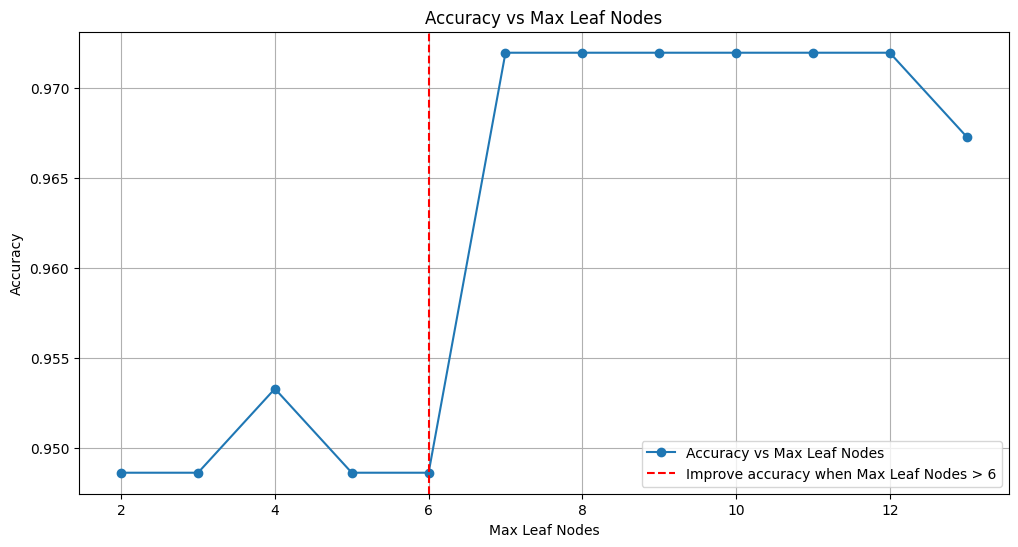

In [2282]:
import matplotlib.pyplot as plt
import numpy as np


# Define the initial values
max_leaf_nodes = 2
maxAccuracy = 0
max_leaf_nodes_values = []
accuracy_values = []
comparison_results = []

while True:
    # Create and fit the model with the current value of max_leaf_nodes
    clf = DecisionTreeClassifier(criterion=best_criterion, splitter=best_splitter, max_depth=best_max_depth, max_leaf_nodes=max_leaf_nodes, random_state=123)
    clf.fit(x_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Add values to the lists
    max_leaf_nodes_values.append(max_leaf_nodes)
    accuracy_values.append(accuracy)

    # Compare with the previous best accuracy and update the comparison results list
    if accuracy > best_accuracy:
        comparison_results.append('Improve')
    elif accuracy < best_accuracy:
        comparison_results.append('Decline')
    else:
        comparison_results.append('Maintains')
    
    # Exit the loop if the accuracy doesn't improve for several values of max_leaf_nodes
    if accuracy <= best_accuracy and max_leaf_nodes > 12:
        break
    
    # Update the best accuracy and the best number of leaf nodes
    if accuracy > best_accuracy:
        maxAccuracy = accuracy
        best_max_leaf_nodes = max_leaf_nodes
    
    # Increase the value of max_leaf_nodes to try the next one
    max_leaf_nodes += 1

# Convert lists to numpy arrays
max_leaf_nodes_values = np.array(max_leaf_nodes_values)
accuracy_values = np.array(accuracy_values)

# Print the results
print("Max Leaf Nodes\tAccuracy")
for i in range(min(15, len(max_leaf_nodes_values))):
    print(f"{max_leaf_nodes_values[i]}\t\t{accuracy_values[i]:.4f}")

# Graph
plt.figure(figsize=(12, 6))
plt.plot(max_leaf_nodes_values, accuracy_values, marker='o', linestyle='-', label='Accuracy vs Max Leaf Nodes')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Leaf Nodes')
plt.axvline(x=6, color='r', linestyle='--', label='Improve accuracy when Max Leaf Nodes > 6')
plt.legend()
plt.grid(True)
plt.show()



### Graphic


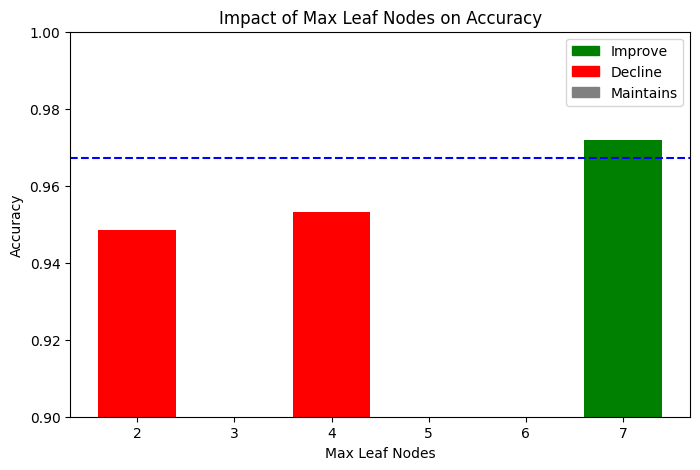

Comparison of Max Leaf Nodes:
  Max Leaf Nodes    Accuracy  Result
----------------  ----------  --------
               2    0.948598  Decline
               4    0.953271  Decline
               7    0.971963  Improve


In [2283]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tabulate import tabulate

# Define the specific values of max_leaf_nodes
specific_max_leaf_nodes = [2, 4, 7]

color_map = {'Improve': 'green', 'Decline': 'red', 'Maintains': 'gray'}
plt.figure(figsize=(8, 5))

# Iterate over the specific values of max_leaf_nodes
for node in specific_max_leaf_nodes:
    index = np.where(max_leaf_nodes_values == node)[0]
    color = color_map[comparison_results[index[0]]]
    plt.bar(node, accuracy_values[index[0]], color=color, label=f'Max Leaf Nodes = {node}')

#Graph
plt.axhline(y=best_accuracy, color='blue', linestyle='--', label=f'Accuracy = {best_accuracy:.4f}')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.title('Impact of Max Leaf Nodes on Accuracy')
plt.ylim(0.9, 1.0)
legend_colors = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_colors)
plt.show()

# Create a list of tuples with the comparison information
comparison_info = [(node, accuracy_values[index], comparison_results[index]) for node, index in zip(specific_max_leaf_nodes, [np.where(max_leaf_nodes_values == node)[0][0] for node in specific_max_leaf_nodes])]

# Print the information
print("Comparison of Max Leaf Nodes:")
print(tabulate(comparison_info, headers=["Max Leaf Nodes", "Accuracy", "Result"]))
